# Hoe kut zijn RE’s?

In [1]:
import plot
import utils
from datetime import datetime

DATETIME_FORMAT = "%Y-%m-%dT%H:%M:%S%z"

In [2]:
data = utils.read_json("data.json")

def line_with_station_info(line, station):
    for key in station["params"]:
        line[f"station_{key}"] = station["params"][key]
    return line


lines = [line_with_station_info(l, station) for station in data.values() for l in station["lines"]]
" | ".join(lines[0].keys())


'tripId | direction | line_name | line_id | admin | type | type_name | operator_name | operator_id | stops | station_key | station_station_id | station_name | station_region | station_country'

In [10]:
def calculate_diff_in_minutes(timestamp1, timestamp2):
    return (datetime.strptime(timestamp2, DATETIME_FORMAT) - datetime.strptime(timestamp1, DATETIME_FORMAT)).total_seconds() / 60

for line in lines:
    def create_segment_object(s1, s2):
        departure = s1["departure"] if s1["departure"] != None else s1["arrival"]
        arrival = s2["arrival"] if s2["arrival"] != None else s2["departure"]
        return {
            "time": calculate_diff_in_minutes(departure, arrival)
        }

    line["segments"] = [create_segment_object(line["stops"][i - 1], s2) for (i, s2) in enumerate(line["stops"]) if i > 0]

    for stop in line["stops"]:
        arrival = stop["arrival"]
        departure = stop["departure"]

        if arrival != None and departure != None:
            stop["time"] = calculate_diff_in_minutes(arrival, departure)
        else: 
            stop["time"] = 0
    
    line["total_time"] = sum([st["time"] for st in line["stops"]]) + sum([seg["time"] for seg in line["segments"]])

lines = [l for l in lines if l["total_time"] > 0]

In [22]:
german_lines = [l for l in lines if l["station_country"] == "D"]
dutch_lines = [l for l in lines if l["station_country"] == "NL"]

german_ic = [l for l in german_lines if l["type"] == "national"]
german_re = [l for l in german_lines if l["type_name"] == "RE"]
dutch_ic = [l for l in dutch_lines if l["type"] == "national"]
dutch_re = [l for l in dutch_lines if l["type"] == "regional"]

## Departures per station

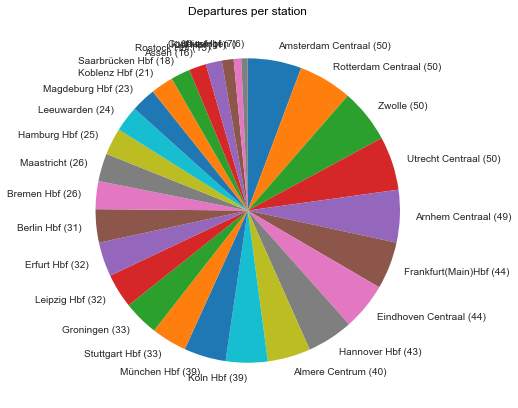

In [5]:
plot.pie(lines, "station_name", count_y=True, sort_by="y", display_absolute_value=True, title="Departures per station")

## Travel time

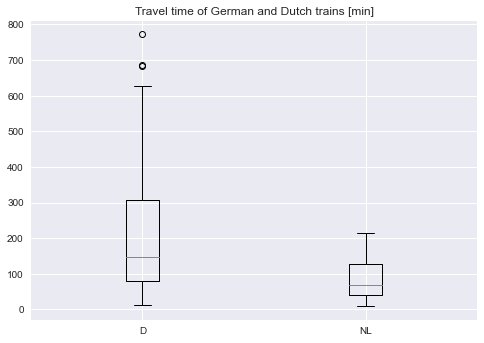

In [12]:
# plot.bar(german_lines, x="total_time", count_y=True, title="Travel time of German trains [min]")
# plot.bar(dutch_lines, x="total_time", count_y=True, title="Travel time of Dutch trains [min]")

plot.box_plot([german_lines, dutch_lines], x="total_time", title="Travel time of German and Dutch trains [min]", x_tick_labels=["D", "NL"])

In [19]:
def print_top_ten(lines_arr, key, reverse=False):
    for (i, l) in enumerate(sorted(lines_arr, key=lambda l: l[key])[:10]):
        print(f"{i+1}: {l['line_name']}: {l['stops'][0]['name']}–{l['stops'][-1]['name']} ({l[key]})")


print("Shortest German lines (time):")
print_top_ten(german_lines, key="total_time")
print()

print("Shortest Dutch lines (time):")
print_top_ten(dutch_lines, key="total_time")

Shortest German lines (time):
1: RB 76: Kiel Hbf–Kiel-Oppendorf (11.0)
2: S 5: Hannover Hbf–Hannover Flughafen (14.0)
3: RB 46: Cottbus Hbf–Forst(Lausitz) (18.0)
4: S 1: Rostock Hbf–Warnemünde (21.0)
5: RE 72: Kiel Hbf–Eckernförde (26.0)
6: HLB RB58: Frankfurt(Main)Hbf–Hanau Hbf (27.0)
7: RB 12: Rostock Hbf–Graal-Müritz (27.0)
8: S 4: Hannover Hbf–Bennemühlen (27.0)
9: S 5: Bietigheim-Bissingen–Stuttgart Schwabstr. (31.0)
10: RB 36: Magdeburg Hbf–Haldensleben (31.0)

Shortest Dutch lines (time):
1: VIA RE19: Arnhem Centraal–Zevenaar (9.0)
2: 5382: Maastricht–Eijsden (10.0)
3: 5383: Maastricht–Eijsden (10.0)
4: RE 8529: Zwolle–Kampen(NL) (11.0)
5: RE 8531: Zwolle–Kampen(NL) (11.0)
6: RE 8533: Zwolle–Kampen(NL) (11.0)
7: RE 8535: Zwolle–Kampen(NL) (11.0)
8: RE 7532: Arnhem Centraal–Ede-Wageningen (15.0)
9: RE 7534: Arnhem Centraal–Ede-Wageningen (15.0)
10: RE 7536: Arnhem Centraal–Ede-Wageningen (15.0)


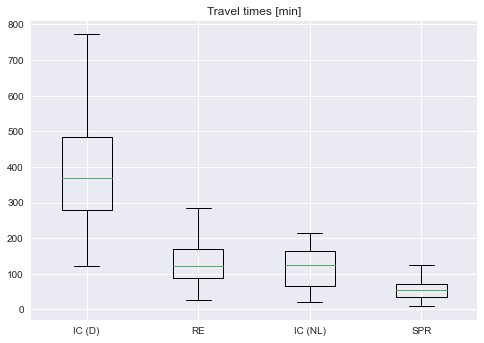

In [23]:
plot.box_plot([german_ic, german_re, dutch_ic, dutch_re], x="total_time", title="Travel times [min]", x_tick_labels=["IC (D)", "RE", "IC (NL)", "SPR"])